# EKF variant comparison (run 10)

Compare the original EKF, single-fix variants, the fully fixed EKF, and the RNN on run 10.

In [1]:
from robot_vlp.config import INTERIM_DATA_DIR, MODELS_DIR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import robot_vlp.stats.navigation_performance as nav
import robot_vlp.modeling.EKF as ekf
import robot_vlp.modeling.ekf_fixed as ekf_fixed
import robot_vlp.data.preprocessing as p

from tensorflow.keras.models import load_model


2026-01-16 20:27:42.119 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


In [2]:
def normalize_angle_rad(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def vec_to_ang(pre_ang):
    return np.arctan2(pre_ang[:, 0], pre_ang[:, 1])


def preprocess_df(df):
    X = df[
        [
            "vlp_x_hist",
            "vlp_y_hist",
            "vlp_heading_hist_rad",
            "vlp_heading_change_rad",
            "encoder_heading_change_rad",
            "encoder_heading_hist_rad",
            "encoder_x_hist",
            "encoder_y_hist",
        ]
    ].values
    y = df[["x_hist", "y_hist", "heading_hist_rad"]].values
    X_win, y_win, _ = p.window_data(X, y, y, overlap=0.999999, window_len=20)
    return X_win, y_win


def compute_errs(ekf_df, df_ref):
    pre_loc = ekf_df[["EKF_x", "EKF_y"]].values
    pre_rad = ekf_df["EKF_heading_rad"].values
    loc_errs = nav.calc_loc_err(pre_loc, df_ref[["x_hist", "y_hist"]].values)
    ang_errs = normalize_angle_rad(pre_rad - df_ref["heading_hist_rad"].values)
    return loc_errs, ang_errs


def run_variant(df, err_stats, fix_jacobian=False, fix_noise=False, heading_source="ekf"):
    ekf_df = ekf_fixed.run_ekf_variant(
        df.copy(),
        err_stats,
        fix_jacobian=fix_jacobian,
        fix_noise_mapping=fix_noise,
        heading_source=heading_source,
    )
    return compute_errs(ekf_df, df)


In [3]:
df_lst = []
for i in range(10):
    test_file = INTERIM_DATA_DIR / "exp_vive_navigated_paths" / f"exp1_{i}_high_acc.csv"
    df_lst.append(pd.read_csv(test_file))

err_stats_original = ekf.calc_err_stats(df_lst[:-1])
err_stats_vlp = ekf_fixed.calc_err_stats(df_lst[:-1])
err_stats_original, err_stats_vlp


({'R_x': 0.0012091360236459105,
  'R_y': 0.0011077760034705292,
  'R_theta': 0.04970905192458874,
  'Q_theta': 0.00021652921772540736,
  'Q_theta_no_turn': 3.982763121767624e-05,
  'Q_dist': 1.7424913153369338e-06},
 {'R_x': 0.0012091360236459105,
  'R_y': 0.0011077760034705292,
  'R_theta': 0.049709051691860094,
  'Q_theta': 0.00021652921772540736,
  'Q_theta_no_turn': 3.982763121767624e-05,
  'Q_dist': 1.7424913153369338e-06})

In [4]:
run_df = df_lst[-1].copy()
apply_encoder_patch = True
slice_start = 20
slice_end = 320

if apply_encoder_patch:
    patch = (
        run_df[["x_hist", "y_hist", "heading_hist_rad"]].iloc[19].values
        - run_df[["encoder_x_hist", "encoder_y_hist", "encoder_heading_hist_rad"]].iloc[19].values
    )
    run_df[["encoder_x_hist", "encoder_y_hist", "encoder_heading_hist_rad"]] = (
        run_df[["encoder_x_hist", "encoder_y_hist", "encoder_heading_hist_rad"]].values + patch
    )

df_eval = run_df.iloc[slice_start:slice_end].reset_index(drop=True)


In [5]:
orig_df = ekf.run_ekf(df_eval.copy(), err_stats_original)
orig_loc_errs, orig_ang_errs = compute_errs(orig_df, df_eval)

loc_fix_jac, ang_fix_jac = run_variant(
    df_eval, err_stats_original, fix_jacobian=True, fix_noise=False, heading_source="ekf"
)
loc_fix_noise, ang_fix_noise = run_variant(
    df_eval, err_stats_original, fix_jacobian=False, fix_noise=True, heading_source="ekf"
)
loc_fix_heading, ang_fix_heading = run_variant(
    df_eval, err_stats_vlp, fix_jacobian=False, fix_noise=False, heading_source="vlp"
)
loc_all_fixed, ang_all_fixed = run_variant(
    df_eval, err_stats_vlp, fix_jacobian=True, fix_noise=True, heading_source="vlp"
)


In [6]:
rnn_model = load_model(MODELS_DIR / "navigation_neural_nets/rnn.keras")

X_win, y_win = preprocess_df(run_df)
X_win = np.nan_to_num(X_win, nan=0)
y_win = np.nan_to_num(y_win, nan=0)

rnn_pre_loc, rnn_pre_ang = rnn_model.predict(X_win)
rnn_loc_errs = nav.calc_loc_err(rnn_pre_loc, y_win[:, :2])
rnn_ang_errs = normalize_angle_rad(vec_to_ang(rnn_pre_ang) - y_win[:, 2])


2026-01-16 20:27:55.041617: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-01-16 20:27:55.041665: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-16 20:27:55.041672: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-01-16 20:27:55.041931: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-16 20:27:55.041955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-01-16 20:27:55.634278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


In [7]:
plot_len = len(orig_loc_errs)

series = {
    "original": (orig_loc_errs[:plot_len], orig_ang_errs[:plot_len]),
    "fix_jacobian": (loc_fix_jac[:plot_len], ang_fix_jac[:plot_len]),
    "fix_noise_mapping": (loc_fix_noise[:plot_len], ang_fix_noise[:plot_len]),
    "fix_heading": (loc_fix_heading[:plot_len], ang_fix_heading[:plot_len]),
    "all_fixed": (loc_all_fixed[:plot_len], ang_all_fixed[:plot_len]),
    "rnn": (rnn_loc_errs[:plot_len], rnn_ang_errs[:plot_len]),
}

for name, (loc_errs, ang_errs) in series.items():
    print(f"{name} pos err mean: {loc_errs.mean()}")
    print(f"{name} heading err mean (deg): {np.degrees(np.abs(ang_errs)).mean()}")
    print("")


original pos err mean: 0.0344865071772824
original heading err mean (deg): 3.507836976311449

fix_jacobian pos err mean: 0.02422025508380114
fix_jacobian heading err mean (deg): 1.2757181253466678

fix_noise_mapping pos err mean: 0.03287399378501988
fix_noise_mapping heading err mean (deg): 3.269939441995274

fix_heading pos err mean: 0.027229860024851185
fix_heading heading err mean (deg): 1.8838530562147553

all_fixed pos err mean: 0.02383280531878033
all_fixed heading err mean (deg): 1.6838347841397872

rnn pos err mean: 0.019798896498900417
rnn heading err mean (deg): 1.9885223018064213



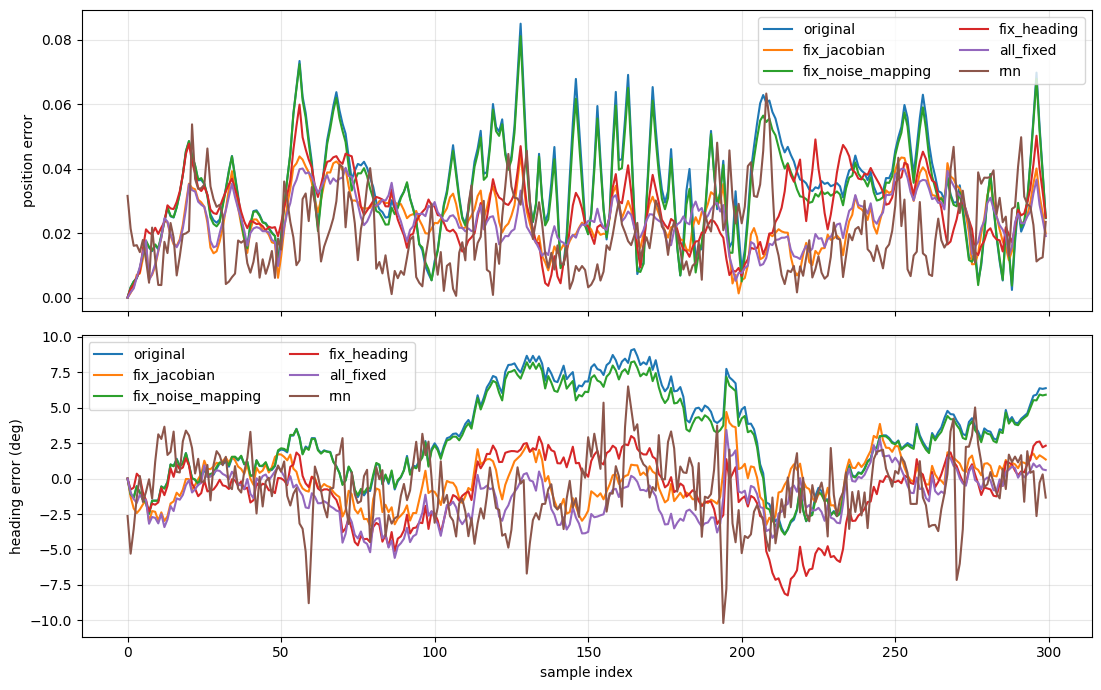

In [8]:
idx = np.arange(plot_len)
fig, axes = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

for name, (loc_errs, ang_errs) in series.items():
    axes[0].plot(idx, loc_errs, label=name)
    axes[1].plot(idx, np.degrees(ang_errs), label=name)

axes[0].set_ylabel("position error")
axes[1].set_xlabel("sample index")
axes[1].set_ylabel("heading error (deg)")

axes[0].legend(ncol=2)
axes[0].grid(True, alpha=0.3)
axes[1].legend(ncol=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
